# Проект для «Викишоп»

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [ ]:
!pip install optuna -q
!pip install optuna-integration -q
!pip install spacy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
import os
import requests
import warnings

import pandas as pd
import numpy as np
import re
import logging

from tqdm import tqdm, notebook
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, confusion_matrix

import optuna
from optuna_integration import OptunaSearchCV
from optuna import distributions

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключение логов optuna
warnings.filterwarnings('ignore')

In [ ]:
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt', quiet=True)

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Константы

In [ ]:
PTH_LOCAL = '/datasets/toxic_comments.csv'
PTH_REMOTE = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

RANDOM_STATE = 42
TEST_SPLIT = 0.25

TARGET = 'toxic'

## Загрузка данных и общая информация

In [ ]:
if os.path.exists(PTH_LOCAL):
    data = pd.read_csv(PTH_LOCAL)
elif requests.head(PTH_REMOTE).status_code == 200:
    data = pd.read_csv(PTH_REMOTE)
else:
    print('Ошибка! Файл не найден.')

In [ ]:
display(data.head(10))
print('=======================================')
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков в таблице не обнаружено. Данные имеют соответсвующий тип данных. Рассмотрим колонку `Unnamed: 0` подробнее:

In [ ]:
data.sample(15)

,Unnamed: 0,text,toxic
84030,84109,"""\n\nSpeedy deletion of Swole\n A tag has been...",0
33742,33782,"@....I have read it brother, what about the re...",0
102378,102475,I have removed the offending adjective and verb.,0
136031,136169,Thanks for The Help\nThanks for the help on Th...,0
74190,74264,"Why are you so anti-muslim? \n\nYo broham, why...",0
22406,22426,"""\nYou haven't been paying attention. I don't ...",1
23771,23791,"Additionally, the above given proof amount to ...",0
7313,7325,awww \n\nyour not simple dont be hard on your ...,0
129839,129975,Why are there no articles in other languages? ...,0
106513,106610,Your merge was worthless; You basically remove...,1


Колонка `Unnamed: 0` где-то дублирует значение индекса, а где-то имеет близкое числовое значение - на таргет это никак не влияет, потому удаляем ее.

In [ ]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

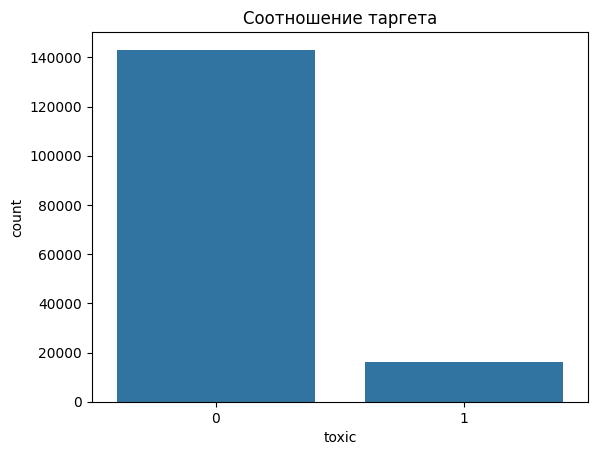

In [ ]:
# Посмотрим на распределение таргета
sns.countplot(data=data, x="toxic")
plt.title('Соотношение таргета');

Заметен явный дисбаланс таргета `toxic` в сторону нетоксичных комментариев (0) в соотношении примерно 1:9.

In [ ]:
# Проверка на явные дубликаты
data.duplicated().sum()

0

Явных дубликатов не найдено.

Для проверки на неявные дубликаты приведем поле `text` к нижнему регистру:

In [ ]:
data['text'] = data['text'].str.lower()

In [ ]:
# Найдем неявные дубликаты
data.duplicated(subset=['text']).sum()

46

In [ ]:
data = data.drop_duplicates(subset=['text'])
print(data.duplicated(subset=['text']).sum())

0


Неявные дубликаты из столбца `text` были успешно удалены.

## Подготовка

Для дальнейшей работы необходимо произвести токенизацию (разбиение текста на токены) и лемматизацию (приведение слова к начальной форме) корпуса текстов. Для этого используем лемматизатор *WordNetLemmatizer* библиотеки *nltk*.

In [ ]:
# Предварительно загрузим список стоп-слов для англ. языка
#stopwords = list(nltk_stopwords.words('english'))

# Загрузка английской языковой модели
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Функция для токенизации и лемматизации текстов с помощью WordNetLemmatizer
# def tok_lemm_func(text):
#     text_cleaned = re.sub(r'[^a-zA-Z]', ' ', text) # c рег. выраж. оставим только буквы алфавита
#     wnl = WordNetLemmatizer() # инициализируем лемматизатор
#     text_tokenized = word_tokenize(text_cleaned)
#     text_lemmatized = ' '.join([wnl.lemmatize(word) for word in text_tokenized])

#     return text_lemmatized

# Функция для токенизации и лемматизации текстов с помощью spaCy
def tok_lemm_func(text):
    text_cleaned = re.sub(r'[^a-zA-Z]', ' ', text) # c рег. выраж. оставим только буквы алфавита
    doc = nlp(text_cleaned) # инициализируем лемматизатор
    text_lemmatized = ' '.join([token.lemma_ for token in doc if not token.is_stop]) # лемматизация токенов и удаление стоп-слов в одной строке
    text_lemmatized_no_large_spaces = re.sub(r'\s+', ' ', text_lemmatized) # замена 2+ пробелов на одинарные
    final_text = text_lemmatized_no_large_spaces.strip() # удаление пробелов в начале и в конце текста

    return final_text

In [ ]:
data['text_lemmatized'] = data['text'].progress_apply(tok_lemm_func)

100%|██████████| 159246/159246 [53:52<00:00, 49.27it/s]


In [ ]:
data.sample(5)

,text,toxic,text_lemmatized
117600,"whow, this is a pitiful excuse for an article....",0,whow pitiful excuse article recommend deletion
10396,new bullet needed for new york city subway \n\...,0,new bullet need new york city subway hi don t ...
2736,"""\n\n ranganathan and the colon classification...",0,ranganathan colon classification spat s famed ...
112015,""", 29 november 2011 (utc)\n\ni don't know what...",0,november utc don t know mean reference article...
148345,please stop. if you continue to vandalize page...,0,stop continue vandalize page attack pearl harb...


Время затраченное на лемматизацию корпуса с использованием *spaCy* составило **примерно 1 час**, а с использованием WordNetLemmatizer (без опций POS) около 2 мин.

## Обучение

### Подготовка датасетов

  
Предварительно проверим не появились ли новые дубликаты после лемматизации:

In [ ]:
data.duplicated(subset=['text_lemmatized']).sum()

2247

Удалим образовавшиеся дубликаты:

In [ ]:
data = data.drop_duplicates(subset=['text_lemmatized'])
print(data.duplicated(subset=['text_lemmatized']).sum())

0


Разделим датасет на тренировочную и тестовую выборки в соотношении 4:1. Учтем дисбаланс классов и используем параметр *stratify*:

In [ ]:
X = data['text_lemmatized']
y = data[TARGET]

X.shape, y.shape

((156999,), (156999,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((117749,), (39250,), (117749,), (39250,))

In [ ]:
# Рассчитаем TF-IDF для дальнейшей работы с моделью
# count_tf_idf = TfidfVectorizer()

# tf_idf_train = count_tf_idf.fit_transform(X_train)
# tf_idf_test = count_tf_idf.transform(X_test)

In [ ]:
# tf_idf_train.shape

### Обучение моделей

In [ ]:
# Создадим список для записи результатов моделей
models_list = []

Для классификации используем 3 модели:

*   *LogisticRegression* (Логистическая регрессия)
*   *DecisionTreeClassifier* (Дерево решений)
*   *SGDClassifier* (Стохастический градиентный спуск)

Для подбора гиперпараметров будем использовать *OptunaSearchCV* в основе которой лежит байесовская оптимизация - данный метод позволяет быстрее находить лучшие значения гиперпараметров, чем случайный поиск (RandomizedSearchCV), и за меньшее количество итераций чем поиск по сетке (*GridSearchCV*).

In [ ]:
# Определим функцию для подбора лучших гиперпараметров
def optuna_func(model, params, model_name, models_list):
  pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("model", model),
    ]
  )

  oscv = OptunaSearchCV(
      pipeline,
      params,
      cv=5,
      n_trials = 100,
      timeout = 600,
      scoring='f1',
      random_state = RANDOM_STATE
  )

  oscv.fit(X_train, y_train)

  new_line = [model_name, oscv.best_score_]
  models_list = models_list.append(new_line)

  print('Лучшие гиперпараметры', oscv.best_params_)
  print('F1-метрика', oscv.best_score_)

  return oscv

**Логистическая регрессия**

In [ ]:
model_LR = LogisticRegression(max_iter=340)
params_LR = {
      'model__C': distributions.IntDistribution(1, 20)
}

In [ ]:
best_LR_model = optuna_func(model_LR, params_LR, 'LogisticRegression', models_list)

Лучшие гиперпараметры {'model__C': 17}
F1-метрика 0.7747034193450781


На кросс-валидации логистическая регрессия показывает приемлимый результат - больше 0,75.

**Дерево решений**

In [ ]:
model_TC = DecisionTreeClassifier(random_state=RANDOM_STATE)
params_TC = {
    'model__min_samples_split': distributions.IntDistribution(2,5),
    'model__min_samples_leaf': distributions.IntDistribution(1,5),
    'model__max_depth': distributions.IntDistribution(2,5)
}

In [ ]:
best_TC_model = optuna_func(model_TC, params_TC, 'DecisionTreeClassifier', models_list)

Лучшие гиперпараметры {'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 5}
F1-метрика 0.5073934405908742


Дерево решений выдает неприемлимо низкую F1-метрику.

**Стохастический градиентный спуск**

In [ ]:
model_SGDC = SGDClassifier(random_state=RANDOM_STATE)
params_SGDC = {
    'model__alpha': distributions.FloatDistribution(1e-6, 1e-3),
    'model__max_iter': distributions.IntDistribution(100, 500)
}

In [ ]:
best_SGDC_model = optuna_func(model_SGDC, params_SGDC, 'SGDClassifier', models_list)

Лучшие гиперпараметры {'model__alpha': 4.247284445326505e-06, 'model__max_iter': 382}
F1-метрика 0.7819754357406805


Стохастический градиентный спуск показал приемлимые результаты - чуть выше таковых чем у логистической регрессии.

In [ ]:
# Выведем все рассчитанные значения в одной таблице
models_df = pd.DataFrame(models_list, columns=['Модель', 'F1 на кросс-валидации']).sort_values(by='F1 на кросс-валидации', ascending=False).reset_index(drop=True)

In [ ]:
models_df

,Модель,F1 на кросс-валидации
0,SGDClassifier,0.781975
1,LogisticRegression,0.774703
2,DecisionTreeClassifier,0.507393


В сравнении с *WordNetLemmatizer* метрика качества увеличилась незначительно - всего-лишь на сотые.

### Анализ моделей

По результатам лучшей моделью с небольшим отрывом оказалсь модель *SGDClassifier* - рассмотрим какое значение F1-метрики она показывает на тестовых данных:

In [ ]:
f1_score_test_best = f1_score(y_test, best_SGDC_model.predict(X_test))

In [ ]:
print(f1_score_test_best)

0.7804810616533038


Наилучшая (по результатам кросс-валидации) модель стохастического градиентного спуска на тестовой выборке выдает удовлетворительный результат - больше 0,75.

В связи с тем, что решаемая задача - это задача бинарной классификации, то дополнительно можно изучить какими получились матрицы ошибок (Confusion matrix) для каждой модели.

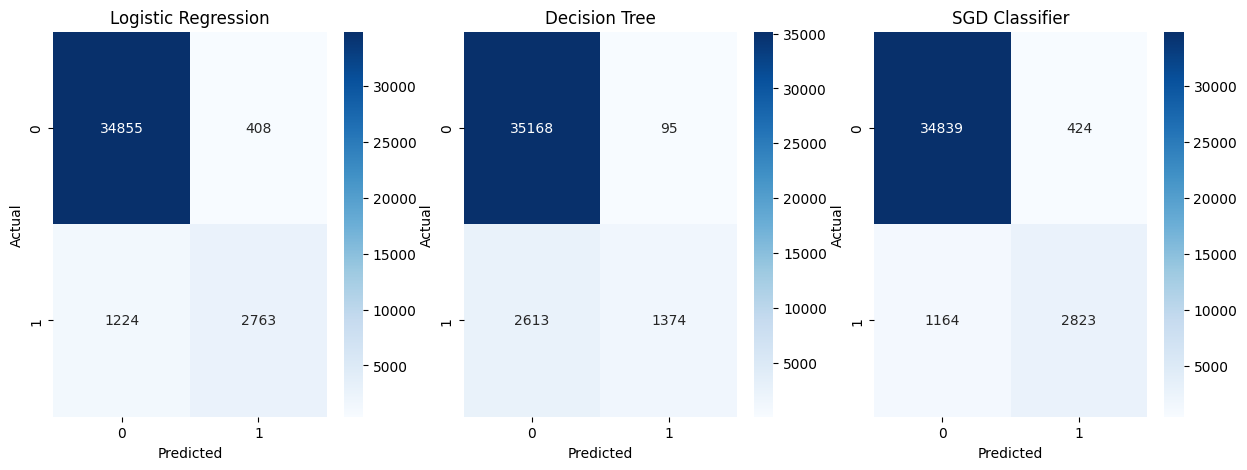

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
models = [best_LR_model, best_TC_model, best_SGDC_model]
model_names = ['Logistic Regression', 'Decision Tree', 'SGD Classifier']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (model, model_name) in enumerate(zip(models, model_names)):
  # model.fit(X_train, y_train)
  preds = model.predict(X_test)

  cm = confusion_matrix(y_test, preds)

  plt.figure()
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
  axes[i].set_title(model_name)
  axes[i].set_xlabel('Predicted')
  axes[i].set_ylabel('Actual');

plt.tight_layout()
plt.show();

Из матрицы каждой модели можно видеть, что логистическая регрессия и градиентый спуск точнее предсказывают "токсичные" комментарии (класс `toxic` = 1).  

# Классификация с использованием нейросети BERT

BERT - нейросеть от компании "Google" для NLP. Для нашего исследования используем distilBERT - легковесную версию BERT.

In [ ]:
import torch
import transformers

Для ускорения работы извлечем только 1000 строк из датасета.

In [ ]:
data_BERT = data.sample(4500).reset_index(drop=True)

Посмотрим как распределен таргет в выборке.

toxic
0    4052
1     448
Name: count, dtype: int64


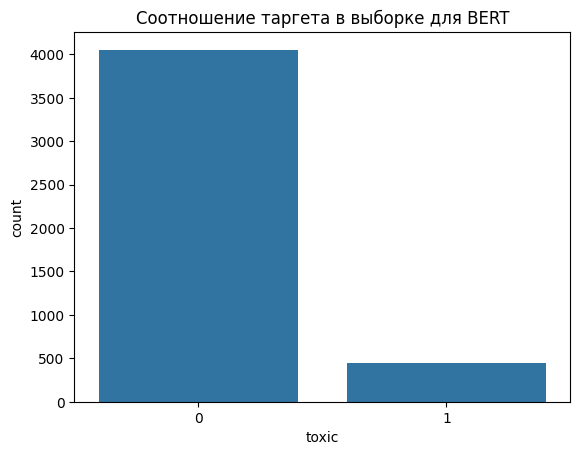

In [ ]:
print(data_BERT['toxic'].value_counts())
print('=====================')
sns.countplot(data=data_BERT, x='toxic')
plt.title('Соотношение таргета в выборке для BERT');

## Инициализация предобученной distilBERT модели

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

## BERT вместо distilBERT? Тогда используем эту строку:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка модели и токенайзера
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Подготовка датасета

In [ ]:
# Токенизация
tokenized = data_BERT['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)))

# Применим метод padding (англ. «отступ»), чтобы после токенизации длины исходных текстов в корпусе были равными - BERT легче работать с такой структурой
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

# Отбросим 0-токены «создав маску» для них
attention_mask = np.where(padded != 0, 1, 0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# Посмотрим на размерности полученных датасетов и максимальную длину предобработанного текста
print('Размерность после предобработки:', np.array(padded).shape)
print('Размерность маски:', np.array(padded).shape)
print('Максимальная длина текста:', max_len)

Размерность после предобработки: (4500, 512)
Размерность маски: (4500, 512)
Максимальная длина текста: 512


## Получение признаков с distilBERT

В эмбедингах будем выделять только ту часть выходных данных, которая нам нужна. Это выходные данные, соответствующие первому символу каждого предложения. Способ, которым BERT классифицирует предложения, заключается в том, что он добавляет символ [CLS] (для классификации) в начале каждого предложения. Выходные данные, соответствующие этому токену, можно рассматривать как эмбединг для всего предложения.

In [ ]:
# Преобразуем данные в формат тензоров — многомерных векторов
# input_ids = torch.tensor(padded)
# attention_mask = torch.tensor(attention_mask)

# Для ускорения вычисления функцией no_grad() библиотеки torch укажем, что градиенты не нужны
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)


# Используем батчи для создания эмбеддингов, а потом соединим
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.tensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.tensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
# features = last_hidden_states[0][:,0,:].numpy()
features = np.concatenate(embeddings)
features.shape

(4500, 768)

In [ ]:
labels = data_BERT['toxic']

## Обучение

### Подготовка датасетов

In [ ]:
models_list_BERT = []

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=labels
)

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((2250, 768), (2250, 768), (2250,), (2250,))

### Обучение моделей

In [ ]:
# Определим аналогичную функцию для подбора лучших гиперпараметров модели BERT (без TF-IDF расчета)
def optuna_func_BERT(model, params, model_name, models_list_BERT):
  oscv = OptunaSearchCV(
      model,
      params,
      cv=5,
      n_trials = 100,
      timeout = 600,
      scoring='f1',
      random_state = RANDOM_STATE
  )

  oscv.fit(train_features, train_labels)

  new_line = [model_name, oscv.best_score_]
  models_list_BERT = models_list_BERT.append(new_line)

  print('Лучшие гиперпараметры', oscv.best_params_)
  print('F1-метрика', oscv.best_score_)

  return oscv

**Логистическая регрессия**

In [ ]:
model_LR_BERT = LogisticRegression(max_iter=350)
params_LR_BERT = {
      'C': distributions.IntDistribution(1, 20)
}

best_LR_model_BERT = optuna_func_BERT(model_LR_BERT, params_LR_BERT, 'LogisticRegression', models_list_BERT)

Лучшие гиперпараметры {'C': 2}
F1-метрика 0.6530166880616174


**Стохастический градиентный спуск**

In [ ]:
model_SGDC_BERT = SGDClassifier(random_state=RANDOM_STATE)
params_SGDC_BERT = {
    'alpha': distributions.FloatDistribution(1e-6, 1e-3),
    'max_iter': distributions.IntDistribution(100, 500)
}

best_SGDC_model_BERT = optuna_func_BERT(model_SGDC_BERT, params_SGDC_BERT, 'SGDClassifier', models_list_BERT)

Лучшие гиперпараметры {'alpha': 0.0007812001529478349, 'max_iter': 489}
F1-метрика 0.6666661688691586


In [ ]:
# Выведем все рассчитанные значения в одной таблице
models_BERT_df = pd.DataFrame(models_list_BERT, columns=['Модель', 'F1 на кросс-валидации']).sort_values(by='F1 на кросс-валидации', ascending=False).reset_index(drop=True)
models_BERT_df

,Модель,F1 на кросс-валидации
0,SGDClassifier,0.666666
1,LogisticRegression,0.653017


### Анализ моделей

По результатам лучшей моделью с небольшим отрывом оказалсь модель стохастического градиентного спуска - рассмотрим какое значение F1-метрики она показывает на тестовых данных:

In [ ]:
f1_score_test_best_BERT = f1_score(test_labels, best_SGDC_model_BERT.predict(test_features))
print(f1_score_test_best_BERT)

0.6597510373443983


## Выводы

Для интернет-магазина "Викишоп" были разработаны и исследованы 3 модели бинарной классификации комментариев (Логистическая регрессия, Дерево решений, Стохастический градиентный спуск) с использованием меры TF-IDF. Для анализа их эффективности была использована метрика F1 - метрика которая позволяет соблюдать баланс между метриками recall и precision - значение которой по условию ТЗ должно быть не ниже 0,75. Можно утверждать, что линейные модели лучше справляются с задачей классификации текстов. По результатам исследования результатов моделей на кросс-валидации и тестовой выборке была выявлена наилучшая: *SGDClassifier* (0.781975 и 0.780481 соотв.).

Для лемматизации были использованы два пакета: *WordNetLemmatizer* и *SpaCy* - второй более прост в работе и производит лемматизацию текстов качественнее, однако имеет значительно большее время работы, а итоговая метрика качества получается не сильно выше.

Для сравнения была исследована работа нейросети distilBERT - классификация производилась на выборке в 4500 текстов (т.е. около 3% от исходной выборки) с разделением на батчи в 100 текстов. По итогу метрика F1 на лучшей модели составила 0.66 - ниже требуемого. Нейросеть оказалась значительно более ресурсоемкой и времязатратной даже на усеченном датасете - возможно при увеличении выборки и вычислительных мощностей удастся получить лучший результат.

Дополнительно были исследованы Матрицы ошибок (Confusion Matrix) из которых можно видеть, что модели *Logistic Regression* и *SGDClassifier* лучше улавливают 'токсичные' комментарии (`toxic` = 1) чем *DecisionTreeClassifier*. При этом при ручном подсчете метрик recall и precision выяснилось, что значение recall несколько уступает precision: т.е. модели чаще ошибаются в обнаружении 'токсичных' комментариев, что может быть связано с дисбалансом классов.

В дальнейшем можно сделать следующее:

* Заказчику можно рекомендовать определить в ТЗ критерии 'токсичности' для исполнителя с целью дополнительной проверки правильности разметки данных. Это может позволить увеличить точность классификации модели и уменьшить дисбаланас классов.

* Для предварительной обработки корпуса текстов можно попробовать применить нейросеть BERT.